## Semantic Segmentation _ EDA

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
with open('/opt/ml/input/data/train_all.json', 'r') as f:
    data_json = json.load(f)

In [3]:
data_json.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [4]:
## info, licenses
print(data_json['info'])
print(data_json['licenses'])

{'year': 2021, 'version': '1.0', 'description': 'Recycle Trash', 'contributor': 'Upstage', 'url': None, 'date_created': '2021-02-02 01:10:00'}
[{'id': 0, 'name': 'CC BY 4.0', 'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}]


In [61]:
# categories
data_cat = pd.DataFrame(data_json['categories'])
data_cat = data_cat[['id', 'name']].set_index('id')
data_cat

,name
id,
1,General trash
2,Paper
3,Paper pack
4,Metal
5,Glass
6,Plastic
7,Styrofoam
8,Plastic bag
9,Battery


### EDA for images & annotations

In [6]:
# Num of images : 3272

json_images = data_json['images']
json_ann = data_json['annotations']
pd_images = pd.DataFrame(json_images)
pd_ann = pd.DataFrame(json_ann)

print(sum(pd_images['height'] != 512))
print(sum(pd_images['width'] != 512))

0
0


count    3271.000000
mean       36.716906
std        42.286954
min         1.000000
25%         7.000000
50%        20.000000
75%        52.000000
max       326.000000
Name: ann_num, dtype: float64


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='ann_num', ylabel='Density'>

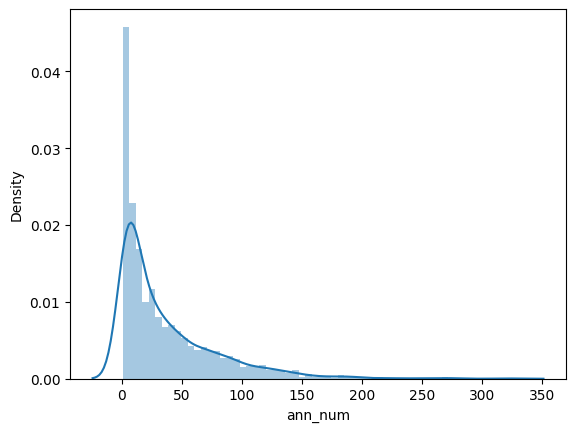

In [7]:
# annotation number per image
pd_images['ann_num'] = pd_ann.pivot_table(index='image_id', aggfunc='sum', values='category_id')
print(pd_images['ann_num'].describe())
sns.distplot(pd_images['ann_num'], bins=60)

In [8]:
# num of annotations : 26240
pd_ann['segmentation'] = pd_ann['segmentation'].apply(lambda x : list(itertools.chain(*x)))
pd_ann['num_pixel'] = pd_ann['segmentation'].apply(lambda x : len(x)//2)

In [55]:
# num of annotations per categories
num_ann = pd_ann.pivot_table(index='category_id', aggfunc='count', values='id')
num_ann.columns = ['num_ann']
num_ann

,num_ann
category_id,
1,2782
2,9311
3,659
4,562
5,610
6,3090
7,1343
8,7643
9,63


In [51]:
# average pixel number in images per categories
avg_pixel_num = pd_ann.pivot_table(index='category_id', aggfunc='mean', values='num_pixel')
avg_pixel_num

,num_pixel
category_id,
1,392.596334
2,499.575019
3,394.641882
4,517.295374
5,522.713115
6,397.936893
7,547.624721
8,575.074709
9,433.793651


In [56]:
# average pixel rate(%) in images per categories
avg_pixel_rate = pd.DataFrame(avg_pixel_num['num_pixel'].apply(lambda x : (100*x) / (512**2)))
avg_pixel_rate.columns = ['avg_pixel(%)']
avg_pixel_rate

,avg_pixel(%)
category_id,
1,0.149764
2,0.190573
3,0.150544
4,0.197333
5,0.199399
6,0.151801
7,0.208902
8,0.219374
9,0.165479


In [62]:
# Overall
overall = pd.concat([data_cat, num_ann, avg_pixel_num, avg_pixel_rate], axis=1)
overall

,name,num_ann,num_pixel,avg_pixel(%)
1,General trash,2782,392.596334,0.149764
2,Paper,9311,499.575019,0.190573
3,Paper pack,659,394.641882,0.150544
4,Metal,562,517.295374,0.197333
5,Glass,610,522.713115,0.199399
6,Plastic,3090,397.936893,0.151801
7,Styrofoam,1343,547.624721,0.208902
8,Plastic bag,7643,575.074709,0.219374
9,Battery,63,433.793651,0.165479
10,Clothing,177,824.774011,0.314626


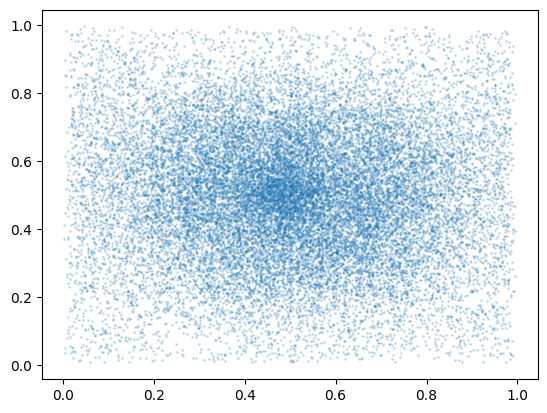

In [49]:
# center of bbox for all images
## bbox : [left x, down y, width, height] format
center_coord = np.array(pd_ann['bbox'].apply(lambda x : [(x[0]+x[2]/2)/512, (x[1]+x[3]/2)/512]).tolist())
xx = center_coord[:, 0]
yy = center_coord[:, 1]

plt.scatter(xx, yy, alpha=0.2, s=1)